# **CNN Assignment**






In [2]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d msarmi9/food101tiny --force

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/msarmi9/food101tiny
License(s): copyright-authors
 92% 88.0M/96.1M [00:01<00:00, 96.5MB/s]
100% 96.1M/96.1M [00:01<00:00, 79.7MB/s]


In [3]:
!unzip -o food101tiny.zip

Archive:  food101tiny.zip
  inflating: data/food-101-tiny/train/apple_pie/1005649.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1014775.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1026328.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1028787.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1043283.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1050519.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1057749.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1057810.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1072416.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1074856.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1074942.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1076891.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1077610.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1077964.jpg  
  inflating: data/food-101-tiny/train/apple_pie/1088809.jpg  
  inflating: data/food-101-tiny/train/apple_

In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
data_dir = 'data/food-101-tiny/'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
train_datagen_1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen_1 = ImageDataGenerator(rescale=1./255)
def load_images_from_directory(directory, target_size=(150, 150)):
    images = []
    labels = []
    label_names = os.listdir(directory)

    for label in label_names:
        class_dir = os.path.join(directory, label)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label_names.index(label))

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

train_images, train_labels = load_images_from_directory(train_dir)
valid_images, valid_labels = load_images_from_directory(valid_dir)
num_classes = len(os.listdir(train_dir))
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)
train_generator_1 = train_datagen_1.flow(
    X_train, y_train, batch_size=32
)

test_generator_1 = valid_datagen_1.flow(
    X_test, y_test, batch_size=32
)

validation_generator_1 = valid_datagen_1.flow(
    valid_images, valid_labels, batch_size=32
)



In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam



model_1 = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3),kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),


    Conv2D(64, (3, 3),kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),


    Conv2D(128, (3, 3),kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),


    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(len(os.listdir(train_dir)), activation='softmax')
])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)

initial_learning_rate = 0.005
model_1.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

model_1.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_36 (Ba  (None, 148, 148, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_36 (Activation)  (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_37 (Ba  (None, 72, 72, 64)       

In [45]:
history = model_1.fit(
    train_generator_1,
    epochs=100,
    validation_data=validation_generator_1,
    callbacks=[reduce_lr]
)


Epoch 1/100
38/38 [==============================] - 10s 166ms/step - loss: 4.2174 - accuracy: 0.1958 - val_loss: 3.6913 - val_accuracy: 0.1400 - lr: 0.0050
Epoch 2/100
38/38 [==============================] - 8s 201ms/step - loss: 3.0327 - accuracy: 0.2683 - val_loss: 3.4020 - val_accuracy: 0.1020 - lr: 0.0050
Epoch 3/100
38/38 [==============================] - 6s 166ms/step - loss: 2.5462 - accuracy: 0.2550 - val_loss: 2.8651 - val_accuracy: 0.1100 - lr: 0.0050
Epoch 4/100
38/38 [==============================] - 8s 198ms/step - loss: 2.2849 - accuracy: 0.2875 - val_loss: 2.9231 - val_accuracy: 0.1000 - lr: 0.0050
Epoch 5/100
38/38 [==============================] - 6s 167ms/step - loss: 2.2650 - accuracy: 0.2608 - val_loss: 2.9771 - val_accuracy: 0.1280 - lr: 0.0050
Epoch 6/100
38/38 [==============================] - 7s 197ms/step - loss: 2.2415 - accuracy: 0.2800 - val_loss: 2.8870 - val_accuracy: 0.1220 - lr: 0.0050
Epoch 7/100
38/38 [==============================] - 7s 180ms/s

In [47]:
loss, accuracy = model_1.evaluate(test_generator_1) #Evaluate using test set
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

10/10 [==============================] - 0s 16ms/step - loss: 1.6237 - accuracy: 0.4900
Loss: 1.6236839294433594
Accuracy: 0.49000000953674316


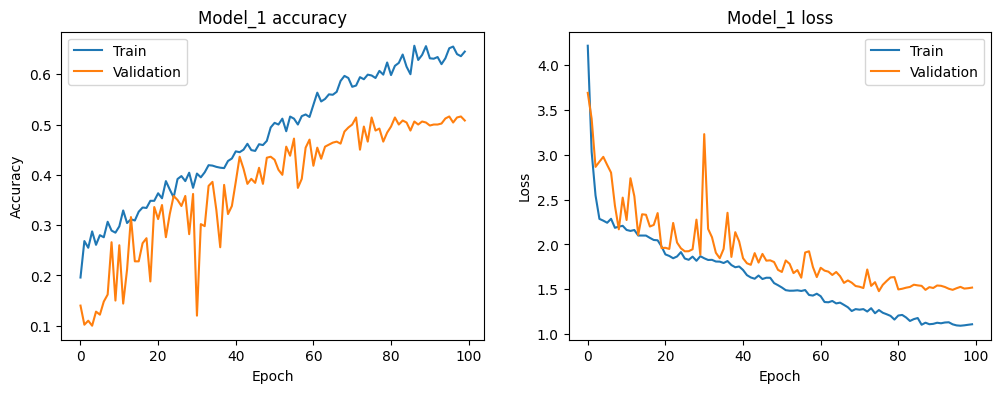

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_1 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_1 loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [58]:
import numpy as np
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Define data directories
data_dir = 'data/food-101-tiny/'
train_dir = os.path.join(data_dir, 'train')

# Get the class labels from the training directory
class_labels = sorted(os.listdir(train_dir))

# Reset the test generator
test_generator_1.reset()

# Initialize arrays to collect predictions and true labels
predicted_classes = []
true_classes = []

# Iterate over the batches from the test generator
for i in range(len(test_generator_1)):
    x_batch, y_batch = test_generator_1[i]
    batch_predictions = model_1.predict_on_batch(x_batch)
    predicted_classes.extend(np.argmax(batch_predictions, axis=1))
    true_classes.extend(np.argmax(y_batch, axis=1))

predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Compute Cohen's Kappa Score
kappa_score = cohen_kappa_score(true_classes, predicted_classes)

# Print confusion matrix and Cohen's Kappa Score
print("Confusion Matrix:")
print(conf_matrix)
print("\nCohen's Kappa Score:", kappa_score)




Confusion Matrix:
[[11  1  2  1  3  1  0  3  4  2]
 [ 0 25  0  0  0  1  1  0  0  1]
 [ 2  0 19  3  0  1  0  0  2  7]
 [ 4  0  5 15  1  2  0  0  1  3]
 [ 1  0  3  1 16  0  3  0  0  1]
 [ 0  1  4  2  4 11  0  1  0  1]
 [ 0  3  3  0  2  3 15  1  0  1]
 [ 2  0  4  1  1  7  3 15  5  0]
 [ 2  0  9  8  3  0  1  1 12  2]
 [ 0  0  6  6  0  2  3  0  1  8]]

Cohen's Kappa Score: 0.4330043358491965
